In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import math

env = gym.make('CartPole-v0')

# 準備 Q table
## Environment 中各個 feature 的 bucket 分配數量
## 1 代表任何值皆表同一 state，也就是這個 feature 其實不重要
n_buckets = (1, 1, 6, 3)

## Action 數量 
n_actions = env.action_space.n

print(env.action_space.n)

## State 範圍 
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_bounds[1] = [-0.5, 0.5]
state_bounds[3] = [-math.radians(50), math.radians(50)]

## Q table，每個 state-action pair 存一值 
q_table = np.zeros(n_buckets + (n_actions,))

# 一些學習過程中的參數
get_epsilon = lambda i: max(0.01, min(1, 1.0 - math.log10((i+1)/25)))  # epsilon-greedy; 隨時間遞減
get_lr = lambda i: max(0.01, min(0.5, 1.0 - math.log10((i+1)/25))) # learning rate; 隨時間遞減 
gamma = 0.99 # reward discount factor

# Q-learning
for i_episode in range(200):
    epsilon = get_epsilon(i_episode)
    lr = get_lr(i_episode)

    observation = env.reset()
    rewards = 0
    state = get_state(observation, n_buckets, state_bounds) # 將連續值轉成離散 
    for t in range(250):
        env.render()

        action = choose_action(state, q_table, env.action_space, epsilon)
        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = get_state(observation, n_buckets, state_bounds)

        # 更新 Q table
        q_next_max = np.amax(q_table[next_state]) # 進入下一個 state 後，預期得到最大總 reward
        q_table[state + (action,)] += lr * (reward + gamma * q_next_max - q_table[state + (action,)]) # 就是那個公式

        # 前進下一 state 
        state = next_state

        if done:
            print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break

env.close()

In [ ]:
import numpy as np

np.random.randint(0, 3)

In [ ]:
np.random.randint(0, 3)

In [2]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
More about Reinforcement learning: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/
Dependencies:
torch: 0.4
gym: 0.8.1
numpy
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym

# Hyper Parameters
BATCH_SIZE = 32
LR = 0.01                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY = 2000
env = gym.make('CartPole-v0')
env = env.unwrapped
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

#print(N_ACTIONS)
#print(N_STATES)


class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        #print(x)
        #print(x.size())
        x = self.fc1(x)
        #print(x)
        #print(x.size())
        x = F.relu(x)
        #print(x)
        #print(x.size())
        actions_value = self.out(x)
        #print(actions_value)
        #print(actions_value.size())
        return actions_value


class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            #print(actions_value)
            action = torch.max(actions_value, 1)[1].data.numpy()
            #print("gd")
            #print(action)
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            #print("rd")
            #print(action)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

dqn = DQN()

print('\nCollecting experience...')
for i_episode in range(1000):
    s = env.reset()
    ep_r = 0
    while True:
        #env.render()
        #print(s.shape)
        a = dqn.choose_action(s)

        # take action
        s_, r, done, info = env.step(a)

        # modify the reward
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        dqn.store_transition(s, a, r, s_)

        ep_r += r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print('Ep: ', i_episode,
                      '| Ep_r: ', round(ep_r, 2))

        if done:
            break
        s = s_


Ep:  205 | Ep_r:  1.35
Ep:  206 | Ep_r:  1.97
Ep:  207 | Ep_r:  3.82
Ep:  208 | Ep_r:  2.97
Ep:  209 | Ep_r:  1.49
Ep:  210 | Ep_r:  5.09
Ep:  211 | Ep_r:  1.72
Ep:  212 | Ep_r:  2.83
Ep:  213 | Ep_r:  5.9
Ep:  214 | Ep_r:  10.94
Ep:  215 | Ep_r:  1.73
Ep:  216 | Ep_r:  1.68
Ep:  217 | Ep_r:  1.88
Ep:  218 | Ep_r:  4.87
Ep:  219 | Ep_r:  12.96
Ep:  220 | Ep_r:  7.79
Ep:  221 | Ep_r:  5.27
Ep:  222 | Ep_r:  3.55
Ep:  223 | Ep_r:  1.33
Ep:  224 | Ep_r:  5.62
Ep:  225 | Ep_r:  10.54
Ep:  226 | Ep_r:  22.5
Ep:  227 | Ep_r:  3.02
Ep:  228 | Ep_r:  13.41
Ep:  229 | Ep_r:  35.49
Ep:  230 | Ep_r:  45.96
Ep:  231 | Ep_r:  6.07
Ep:  232 | Ep_r:  24.23
Ep:  233 | Ep_r:  28.21
Ep:  234 | Ep_r:  58.15
Ep:  235 | Ep_r:  148.96
Ep:  236 | Ep_r:  63.07
Ep:  237 | Ep_r:  219.01
Ep:  238 | Ep_r:  500.28
Ep:  239 | Ep_r:  362.26
Ep:  240 | Ep_r:  96.82
Ep:  241 | Ep_r:  1004.62
Ep:  242 | Ep_r:  974.88
Ep:  243 | Ep_r:  176.85
Ep:  244 | Ep_r:  1083.69
Ep:  245 | Ep_r:  353.29
Ep:  246 | Ep_r:  115.32
E

Ep:  541 | Ep_r:  158.31
Ep:  542 | Ep_r:  490.88
Ep:  543 | Ep_r:  485.19
Ep:  544 | Ep_r:  156.04
Ep:  545 | Ep_r:  1472.55
Ep:  546 | Ep_r:  445.24
Ep:  547 | Ep_r:  239.9
Ep:  548 | Ep_r:  677.91
Ep:  549 | Ep_r:  306.51
Ep:  550 | Ep_r:  469.98
Ep:  551 | Ep_r:  389.52
Ep:  552 | Ep_r:  249.27
Ep:  553 | Ep_r:  202.99
Ep:  554 | Ep_r:  626.16
Ep:  555 | Ep_r:  159.45
Ep:  556 | Ep_r:  764.57
Ep:  557 | Ep_r:  285.58
Ep:  558 | Ep_r:  841.34
Ep:  559 | Ep_r:  453.71
Ep:  560 | Ep_r:  298.98
Ep:  561 | Ep_r:  813.6
Ep:  562 | Ep_r:  1767.29
Ep:  563 | Ep_r:  225.72
Ep:  564 | Ep_r:  180.43
Ep:  565 | Ep_r:  191.19
Ep:  566 | Ep_r:  333.5
Ep:  567 | Ep_r:  449.52
Ep:  568 | Ep_r:  474.23
Ep:  569 | Ep_r:  122.56
Ep:  570 | Ep_r:  405.14
Ep:  571 | Ep_r:  274.91
Ep:  572 | Ep_r:  487.9
Ep:  573 | Ep_r:  1311.54
Ep:  574 | Ep_r:  391.82
Ep:  575 | Ep_r:  205.94
Ep:  576 | Ep_r:  831.22
Ep:  577 | Ep_r:  369.82
Ep:  578 | Ep_r:  1144.38
Ep:  579 | Ep_r:  707.31
Ep:  580 | Ep_r:  433.23


Ep:  868 | Ep_r:  352.27
Ep:  869 | Ep_r:  184.17
Ep:  870 | Ep_r:  370.97
Ep:  871 | Ep_r:  659.29
Ep:  872 | Ep_r:  182.73
Ep:  873 | Ep_r:  418.76
Ep:  874 | Ep_r:  418.15
Ep:  875 | Ep_r:  321.72
Ep:  876 | Ep_r:  260.04
Ep:  877 | Ep_r:  370.13
Ep:  878 | Ep_r:  612.88
Ep:  879 | Ep_r:  654.0
Ep:  880 | Ep_r:  280.08
Ep:  881 | Ep_r:  399.54
Ep:  882 | Ep_r:  1312.03
Ep:  883 | Ep_r:  248.61
Ep:  884 | Ep_r:  150.2
Ep:  885 | Ep_r:  296.54
Ep:  886 | Ep_r:  256.17
Ep:  887 | Ep_r:  495.24
Ep:  888 | Ep_r:  323.36
Ep:  889 | Ep_r:  460.85
Ep:  890 | Ep_r:  499.98
Ep:  891 | Ep_r:  214.71
Ep:  892 | Ep_r:  452.92
Ep:  893 | Ep_r:  219.89
Ep:  894 | Ep_r:  161.3
Ep:  895 | Ep_r:  419.7
Ep:  896 | Ep_r:  284.31
Ep:  897 | Ep_r:  365.1
Ep:  898 | Ep_r:  400.48
Ep:  899 | Ep_r:  228.08
Ep:  900 | Ep_r:  554.79
Ep:  901 | Ep_r:  616.26
Ep:  902 | Ep_r:  859.15
Ep:  903 | Ep_r:  445.11
Ep:  904 | Ep_r:  523.81
Ep:  905 | Ep_r:  48.21
Ep:  906 | Ep_r:  325.08
Ep:  907 | Ep_r:  1131.99
Ep: 

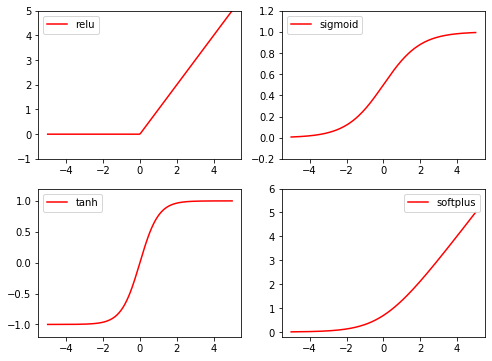

In [2]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:
torch: 0.4
matplotlib
"""
%matplotlib inline
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# fake data
x = torch.linspace(-5, 5, 200)  # x data (tensor), shape=(100, 1)
x = Variable(x)
x_np = x.data.numpy()   # numpy array for plotting

# following are popular activation functions
y_relu = torch.relu(x).data.numpy()
y_sigmoid = torch.sigmoid(x).data.numpy()
y_tanh = torch.tanh(x).data.numpy()
y_softplus = F.softplus(x).data.numpy() # there's no softplus in torch
# y_softmax = torch.softmax(x, dim=0).data.numpy() softmax is a special kind of activation function, it is about probability

# plt to visualize these activation function
plt.figure(1, figsize=(8, 6))
plt.subplot(221)
plt.plot(x_np, y_relu, c='red', label='relu')
plt.ylim((-1, 5))
plt.legend(loc='best')

plt.subplot(222)
plt.plot(x_np, y_sigmoid, c='red', label='sigmoid')
plt.ylim((-0.2, 1.2))
plt.legend(loc='best')

plt.subplot(223)
plt.plot(x_np, y_tanh, c='red', label='tanh')
plt.ylim((-1.2, 1.2))
plt.legend(loc='best')

plt.subplot(224)
plt.plot(x_np, y_softplus, c='red', label='softplus')
plt.ylim((-0.2, 6))
plt.legend(loc='best')

plt.show()

In [2]:
def dog():
    height = 40
    
    def profile():
        print("I'm a dog and my height is {}.".format(height))
        
    return profile



if __name__ == "__main__":
    dog_profile = dog()